# Tutorial: Ellipsometry algorithm benchmark

In [1]:
# install dependecies
!pip install pymoosh
!pip install nevergrad

## load modules

In [2]:
import time
import copy

import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np
from tqdm import tqdm

## setup model, problem and optimizer

First we repeat the setup of the ellipsometry problem

In [3]:
def setup_structure(x, mat_env, mat_substrate):
    """helper to create pymoosh structure object with user-defined thicknesses and materials

    Args:
        X (list): long list of material permittivities and thicknesses (first half / second half)
        mat_env (float, str): material of environment (above stack)
        mat_substrate (float, str): material of substrate (below stack)

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    x = list(x)  # convert to list for convenience when stacking layers
    n_layers = len(x) // 2

    # available materials
    materials = [mat_env] + [_m for _m in x[:n_layers]] + [mat_substrate]
    # material sequence of layer-stack
    stack = [i for i in range(n_layers + 2)]
    # thicknesses of layers
    thicknesses = np.array([0] + [_t for _t in x[n_layers:]] + [0])

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure


# ------- the optimization target function -------
def cost_ellipsometry(x, ref_ellipso, mat_env, mat_substrate, wavelengths, angle):
    """ cost function: MAE between simulated and measured (ref) spectrum

    Args:
        x (list): materials (first half) & thicknesses (second half) of all layers
        ref_ellipso (np.ndarray): reference spectrum at `eval_wls`
        wavelengths (np.ndarray): wavelengths to evaluate

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x, mat_env, mat_substrate)

    # the actual PyMoosh reflectivity simulation
    ellips = np.zeros(len(wavelengths), dtype=np.complex128)
    for i, wav in enumerate(wavelengths):
        r_s, _, _, _ = pm.coefficient(structure, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(structure, wav, angle, 1)
        ellips[i] = r_p/r_s

    # diff = ellips - ref_ellipso
    cost = np.mean(np.abs(ellips.imag - ref_ellipso.imag)**2 +
                   np.abs(ellips.real - ref_ellipso.real)**2)

    return cost


# ------- define "ellispometry" optimization problem
mat_env = 1.0
mat_substrate = 'Gold'
nb_layers = 1
min_thick = 50     # nm
max_thick = 150
min_eps = 1.1      # permittivity
max_eps = 3
wavelengths = np.linspace(400, 800, 31)  # nm
angle = 40*np.pi/180  # rad

## setup random reference generator

For a better robustness evaluation, we want to run every test-optimization with a separate reference layer. Therefore we write a helper function to later do this in a single line

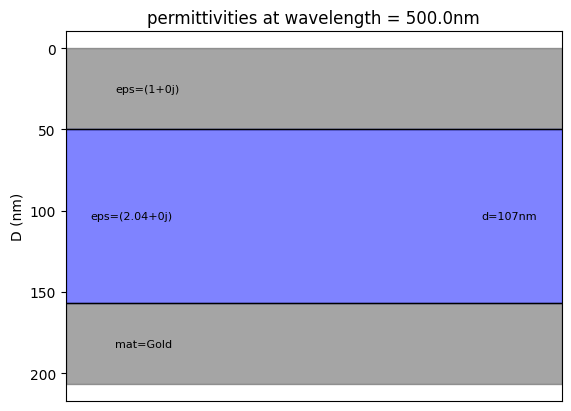

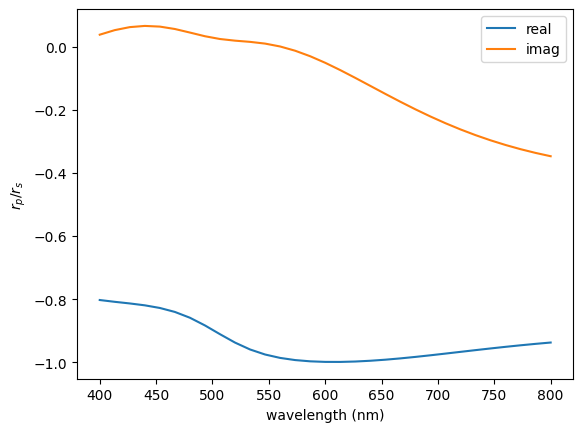

In [4]:
def gen_random_reference(
            min_eps, max_eps, min_thick, max_thick,
            mat_env, mat_substrate, wavelengths, angle,
            nb_layers=1):
    # create a reference structure that we then try to find
    x_ref = [np.random.random()*(max_eps-min_eps) +
                            min_eps for _ in range(nb_layers)]
    x_ref += [np.random.random()*(max_thick-min_thick) +
                            min_thick for _ in range(nb_layers)]
    struct_ref = setup_structure(x_ref, mat_env, mat_substrate)

    # calculate reference r_p/r_s spectrum (equiv. to ellispometry measurement)
    ref_ellipso = np.zeros(len(wavelengths), dtype=complex)
    for i, wav in enumerate(wavelengths):
        r_s, _, _, _ = pm.coefficient(struct_ref, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(struct_ref, wav, angle, 1)
        ref_ellipso[i] = r_p / r_s

    return x_ref, struct_ref, ref_ellipso


# generate and plot a reference
x_ref, struct_ref, ref_ellipso = gen_random_reference(
            min_eps, max_eps, min_thick, max_thick,
            mat_env, mat_substrate, wavelengths, angle,
            nb_layers)

plt.figure()
plt.subplot(title='reference structure (which we try to find via ellipsometry)')
struct_ref.plot_stack()

plt.figure()
plt.plot(wavelengths, ref_ellipso.real, label='real')
plt.plot(wavelengths, ref_ellipso.imag, label='imag')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('$r_p / r_s$')
plt.show()


## Setup the optimizer

## Running multiple optimizations

run the optimization with several optimizers in an attempt to find the best suited algorithm for our problem.

In [5]:
budget = 20 * 2 * nb_layers    # stop criterion: allowed number of evaluations
N_repet_each = 20 # how often to repeat the run with each optimizer

# iterate through list of algorithms to use
list_optims = ["BFGS", "PSO", "QODE", "QNDE", "DE", "CMA", "NGOpt"]

# init results container dict
hist_cost = {}
hist_best_f = {}
for optim_name in list_optims:
    hist_cost[optim_name] = []
    hist_best_f[optim_name] = []

# perform optimizations
for optim_name in list_optims:
    print('running optimizer: "{}"'.format(optim_name))

    # run the optimizer multiple times
    t0 = time.time()
    for k in tqdm(range(N_repet_each)):
        # generate a new, random reference
        x_ref, struct_ref, ref_ellipso = gen_random_reference(
                    min_eps, max_eps, min_thick, max_thick,
                    mat_env, mat_substrate, wavelengths, angle,
                    nb_layers)


        # initialize the parametrization and the optimizer
        # ------- setup the parametrization
        # # bounds for free params: layer permittivities and thicknesses
        args_mat_thick_ng = ng.p.Array(
            shape=(2 * nb_layers,),
            lower=[min_eps]*nb_layers + [min_thick]*nb_layers,
            upper=[max_eps]*nb_layers + [max_thick]*nb_layers,
        )

        # wrap free and fixed arguments
        instru = ng.p.Instrumentation(
            # --- optimization args
            x=args_mat_thick_ng,

            # --- additional, fixed args
            ref_ellipso=ref_ellipso,
            mat_env=mat_env,
            mat_substrate=mat_substrate,
            wavelengths=wavelengths,
            angle=angle,
        )
        instru[1]['ref_ellipso'] = ref_ellipso # replace reference by new one
        optimizer = ng.optimizers.registry[optim_name](instru, budget)

        # init tracking values
        best_f = float("inf") # container for best solution
        yval = []             # container for convergence curve

        # the actual optimization loop
        for k in range(budget):
            x = optimizer.ask()   # get suggestion for new test structure

            y = cost_ellipsometry(**x.value[1]) # eval. the optimizer's suggestion
            optimizer.tell(x, y)  # tell the cost to the optimizer

            if y < best_f:
                best_f = y
            yval.append(best_f)

        # add results of run to history
        hist_cost[optim_name].append(yval)
        hist_best_f[optim_name].append(best_f)


running optimizer: "BFGS"


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


running optimizer: "PSO"


100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


running optimizer: "QODE"


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


running optimizer: "QNDE"


100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


running optimizer: "DE"


100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


running optimizer: "CMA"


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/cma/evolution_strategy.py:2981: InjectionWarning: orphanated injected solution {'iteration': 1, 'index': 0, 'counter': 0}
                        This could be a bug in the calling order/logics or due to
                        a too small popsize used in `ask()` or when only using
                        `ask(1)` repeatedly. Please check carefully.
                        In case this is desired, the warning can be surpressed with
                        ``warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)``
                        
  warnings.warn("""orphanated injected solution %s
/usr/local/lib/python3.10/dist-packages/cma/evolution_strategy.py:2981: InjectionWarning: orphanated injected solution {'iteration': 2, 'index': 0, 'counter': 1}
                        This could be a bug in the calling order/logics or due to
                        a too small popsize used in `ask()` or wh

running optimizer: "NGOpt"


100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


## Plot the convergence

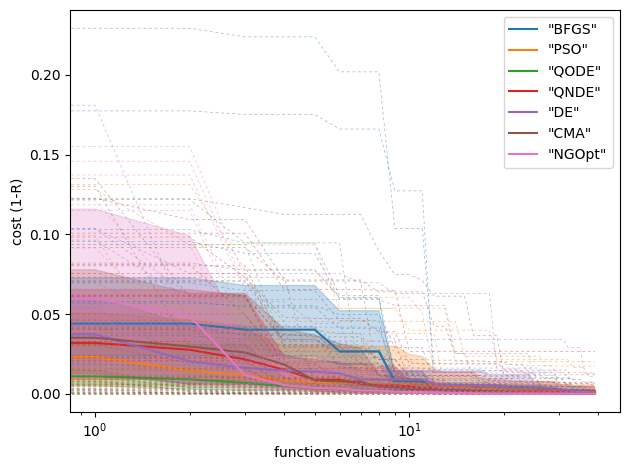

In [6]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])

    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{k}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])),
                     np.quantile(hist_cost[k], 0.25, axis=0),
                     np.quantile(hist_cost[k], 0.75, axis=0),
                     color=colors[i_opt],
                     alpha=0.25)

plt.xscale('log')

plt.xlabel('function evaluations')
plt.ylabel('cost (1-R)')
plt.legend()

plt.tight_layout()
plt.show()

## plot the consistency test

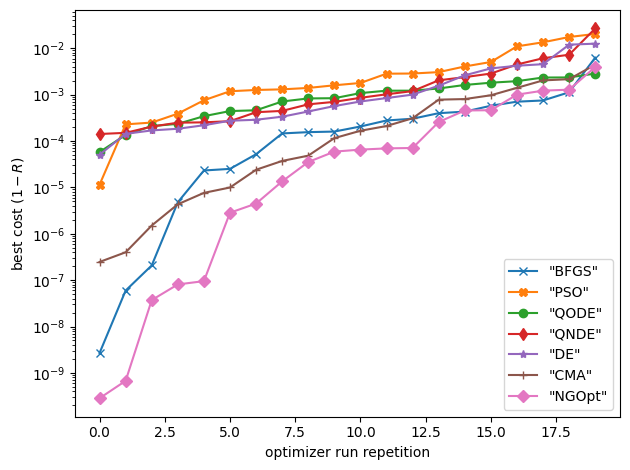

In [9]:
colors = [f'C{i}' for i in range(10)]
markers = ['x', 'X', 'o', 'd', '*', '+', 'D']

for i_opt, k in enumerate(hist_best_f):
    plt.plot(np.sort(hist_best_f[k]), color=colors[i_opt], marker=markers[i_opt], label=f'"{k}"')

plt.xlabel('optimizer run repetition')
plt.ylabel('best cost ($1-R$)')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()